# "Hi, Zain here."

## Here is my go through the reviews data on a Colab notebook

# **Data Science Practical Test**
## Instructions
Analyse and use a machine learning model with the Amazon Kindle reviews data provided. You may decide what to do with the data as long as the following criterias are met:


1. Define the aim of the project
2. Use a machine learning model
3. Assess the quality of the model with appropriate metric(s)
4. Use any visualisation as appropriate
5. Write succinct documentation
6. All work, including any pre-processing, must be done in this notebook
7. Must use Python


## Rules
* You have 24 hours to complete this task
* Email completed project to anita@partly.com
* Any submission after the deadline will be discounted
* Copying from any existing project is not allowed




# Data
Download the data here: https://drive.google.com/file/d/1bXotNR-Rwvlim89LZkii62wS4HKm2ceX/view?usp=sharing

The provided data is a sample of 982,619 reviews from the Amazon Kindle store.

Columns:
* `reviewerID` - ID of the reviewer, e.g. A2SUAM1J3GNN3B
* `asin` - ID of the product, e.g. 0000013714
* `reviewerName` - name of the reviewer
* `helpful` - helpfulness rating of the review, e.g. 2/3
* `reviewText` - text of the review
* `overall` - rating of the product
* `summary` - summary of the review
* `unixReviewTime` - time of the review (unix time)
* `reviewTime` - time of the review (raw)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import nltk #
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer #
from nltk.corpus import wordnet #
import spacy #
from scipy.sparse import hstack #
from textblob import TextBlob #
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed
from sklearn.feature_extraction.text import TfidfVectorizer #
import os
num_cores = os.cpu_count()
print(f'Number of CPU Cores: {num_cores}')
from afinn import Afinn #

# too complex libraries to run on a free notebook on google colab

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Number of CPU Cores: 2


In [3]:
#Loading data
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/review_Kindle_Store.csv')

In [4]:
df.head() # getting a feel to decide the aim of the project

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1F6404F1VG29J,B000F83SZQ,Avidreader,"[0, 0]",I enjoy vintage books and movies so I enjoyed ...,5.0,Nice vintage story,1399248000,"05 5, 2014"
1,AN0N05A9LIJEQ,B000F83SZQ,critters,"[2, 2]",This book is a reissue of an old one; the auth...,4.0,Different...,1388966400,"01 6, 2014"
2,A795DMNCJILA6,B000F83SZQ,dot,"[2, 2]",This was a fairly interesting read. It had ol...,4.0,Oldie,1396569600,"04 4, 2014"
3,A1FV0SX13TWVXQ,B000F83SZQ,"Elaine H. Turley ""Montana Songbird""","[1, 1]",I'd never read any of the Amy Brewster mysteri...,5.0,I really liked it.,1392768000,"02 19, 2014"
4,A3SPTOKDG7WBLN,B000F83SZQ,Father Dowling Fan,"[0, 1]","If you like period pieces - clothing, lingo, y...",4.0,Period Mystery,1395187200,"03 19, 2014"


In [5]:
df.describe # more of getting a feel for the data

<bound method NDFrame.describe of             reviewerID        asin                         reviewerName  \
0       A1F6404F1VG29J  B000F83SZQ                           Avidreader   
1        AN0N05A9LIJEQ  B000F83SZQ                             critters   
2        A795DMNCJILA6  B000F83SZQ                                  dot   
3       A1FV0SX13TWVXQ  B000F83SZQ  Elaine H. Turley "Montana Songbird"   
4       A3SPTOKDG7WBLN  B000F83SZQ                   Father Dowling Fan   
...                ...         ...                                  ...   
982614  A2Y66HD4J5S7QZ  B00M13FNSS                                Candi   
982615  A17YHECC8H9NEY  B00M13FNSS                               Margie   
982616  A20KO0BPMNREJL  B00M13FNSS                                Nicki   
982617  A1BQO66R6OLCCW  B00M13FNSS                                Nikey   
982618  A2NRGE3CSFY2TQ  B00M13FNSS                                   Yo   

       helpful                                         reviewText

# Lets do some basic EDA

In [6]:
df.isna().sum()
# NA's in reviewer Name could be anonymous or not regular users or they are they are just lazy.

reviewerID           0
asin                 0
reviewerName      3816
helpful              0
reviewText          22
overall              0
summary              1
unixReviewTime       0
reviewTime           0
dtype: int64

In [7]:
df[df.isna().any(axis=1)] # other cols have relevant info, Keeping ut until a model throws an NA error

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
385,A2VQLTC61OV8U3,B000JQUTGK,NaN,"[0, 0]",Not very well written but historical details i...,4.0,Four Stars,1405555200,"07 17, 2014"
718,A3VXGX6X6B63K,B000SRGF2W,NaN,"[0, 0]",I won this book from Denise Agnew. I liked it...,5.0,Nice surprise,1405468800,"07 16, 2014"
1430,APFZA56X7OV1C,B0016IXMDW,NaN,"[0, 0]",This book starts as a typical &#34;friend to l...,3.0,Touching Lace,1405468800,"07 16, 2014"
1473,AGSGL6VT17RE0,B0017I7XY0,NaN,"[2, 2]",I thought this would be a great book after rea...,3.0,Unbroken and not interesting.,1405296000,"07 14, 2014"
2389,AH6X24URFY1RB,B001GPOO64,NaN,"[0, 0]","Sexy, passionate",4.0,Four Stars,1405814400,"07 20, 2014"
...,...,...,...,...,...,...,...,...,...
975669,A3QJM84HTB7KC6,B00LHUSSSI,NaN,"[1, 1]",Clara is a foster carer but she has doubts abo...,5.0,Mesermising and Super Story,1404432000,"07 4, 2014"
975805,A3QJM84HTB7KC6,B00LI491GG,NaN,"[2, 2]",It is rare to come across such a good treatise...,5.0,"Excellent Marketing Tips, Especially what Mist...",1404432000,"07 4, 2014"
978062,A2G0JB0QWVG62X,B00LLJ6VEI,NaN,"[0, 0]",a really nice wartime romance novel... gentle ...,5.0,good read,1404950400,"07 10, 2014"
978625,A3AR07P2TQNUXS,B00LM1SHXI,NaN,"[1, 1]",This is another great book by my favorite auth...,5.0,Love this book!,1405123200,"07 12, 2014"


Some EDA to get some handle of the data

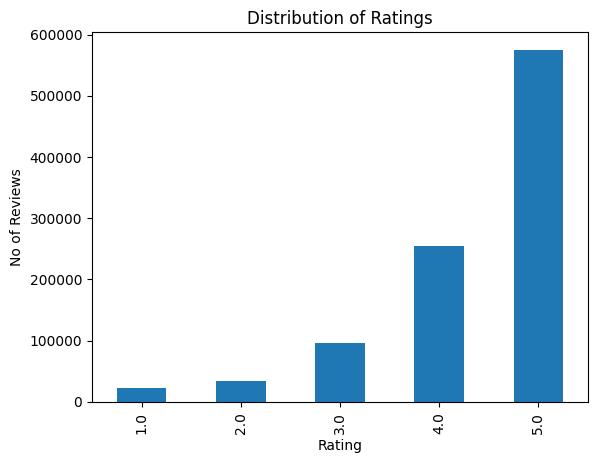

In [8]:
# Viz the distribution of ratings to get more of a feel
df['overall'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('No of Reviews')
plt.show()


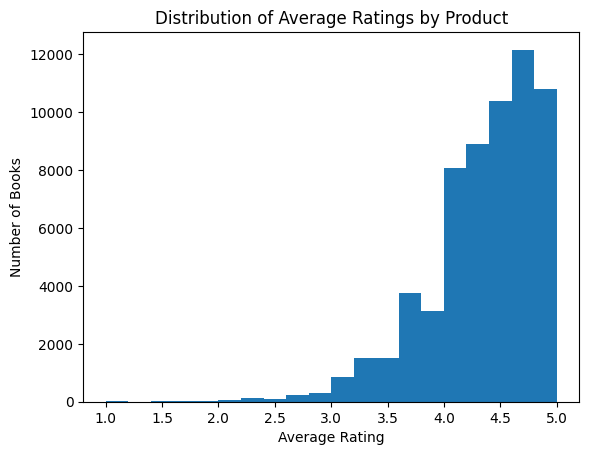

In [9]:
df.groupby('asin')['overall'].mean().plot(kind='hist', bins=20)
plt.title('Distribution of Average Ratings by Product')
plt.xlabel('Average Rating')
plt.ylabel('Number of Books')
plt.show()
# this also follows the above, the distribution is skewd towards higher ratings

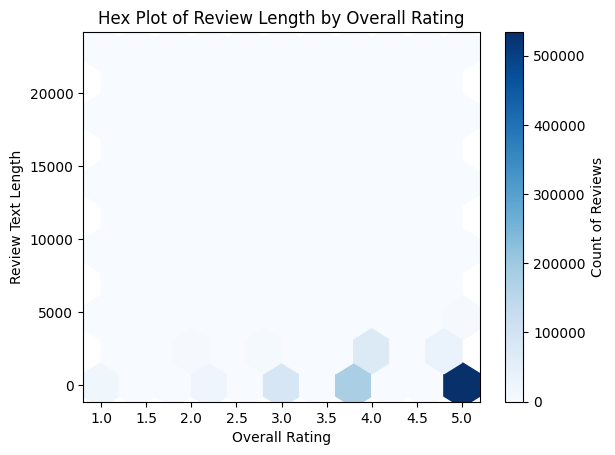

In [10]:
# I like geom_hex in R, v nice to see distribution in crowded data
df['reviewText_length'] = df['reviewText'].apply(lambda x: len(str(x)))
plt.hexbin(df['overall'], df['reviewText_length'], gridsize=10, cmap='Blues')
plt.colorbar(label='Count of Reviews')
plt.xlabel('Overall Rating')
plt.ylabel('Review Text Length')
plt.title('Hex Plot of Review Length by Overall Rating')
plt.show()

This hex plot does show that we have more words for higher reviews. we can look out for this in our results

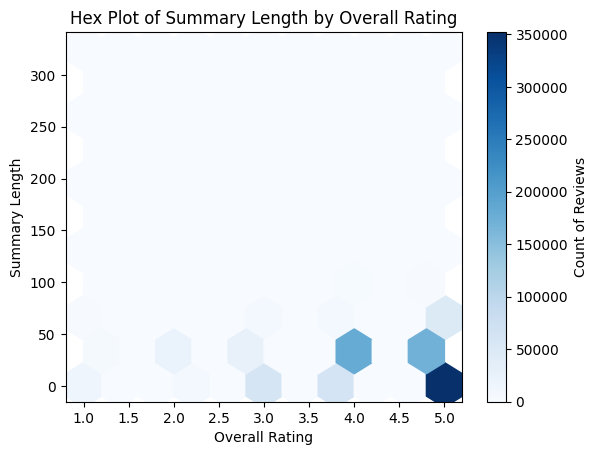

In [11]:
# repeat for summary
df['summary_length'] = df['summary'].apply(lambda x: len(str(x)))
plt.hexbin(df['overall'], df['summary_length'], gridsize=10, cmap='Blues')
plt.colorbar(label='Count of Reviews')
plt.xlabel('Overall Rating')
plt.ylabel('Summary Length')
plt.title('Hex Plot of Summary Length by Overall Rating')
plt.show()

Same effect seems to for Summaries of review

# Aim of the Project:
## To predict the Popularity of the books from the reviews using the data incl summary, reviewText, helpfulness.
also there are a few medium and Github repos for Sentiment Analysis for this data so lets try sth new and useful which could translate into PARTLY's marketplace. Also kept it simple enough for my current level of NLP understanding

We could definitely include more variables like time, anmes to account for skews biases, like gender from names etc.



In [12]:
df['helpful_votes'] = df['helpful'].apply(lambda x: eval(x)[0])
df['total_votes'] = df['helpful'].apply(lambda x: eval(x)[1])
df['helpful_ratio'] = df['helpful_votes'] / (df['total_votes'] + 1e-5)
df['is_helpful'] = (df['helpful_ratio'] > 0.5).astype(int)
df['combined_text'] = df['summary'].astype(str) + ' ' + df['reviewText'].astype(str)


In [13]:
# Calculate sentiment polarity for each review and summary
#def get_sentiment(text):
#    return TextBlob(str(text)).sentiment.polarity

# Run in parallel
#df['review_sentiment'] = Parallel(n_jobs=-1)(delayed(get_sentiment)(text) for text in df['reviewText'])
#df['summary_sentiment'] = Parallel(n_jobs=-1)(delayed(get_sentiment)(text) for text in df['summary'])
#df['review_sentiment'] = df['reviewText'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
#df['summary_sentiment'] = df['summary'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# not enough compute power on a free google colab to run the above in time. lets do sth else
#afinn = Afinn()
# lets hope this is quicker
#df['review_sentiment'] = df['combined_text'].apply(lambda text: afinn.score(text))
#def get_afinn_sentiment(text):
#    return afinn.score(text)
#df['review_sentiment'] = Parallel(n_jobs=-1)(delayed(get_afinn_sentiment)(text) for text in df['combined_text'])
#df['sentiment'] = df['combined_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)


### NLP is out of the window, because of shortage of resources. not a great look honestly. But i guess you have an idea where I was going to use that

In [14]:
# feature extraction

book_features = df.groupby('asin').agg({'overall': 'mean',
                                        #'review_sentiment': 'mean',
                                        'helpful_ratio': 'mean',
                                        'reviewerID': 'count'})
book_features.describe()


,overall,helpful_ratio,reviewerID
count,61934.000000,61934.000000,61934.000000
mean,4.345429,0.402065,15.865583
std,0.500079,0.280897,21.420064
min,1.000000,0.000000,5.000000
25%,4.071429,0.166666,6.000000
50%,4.428571,0.363633,9.000000
75%,4.727273,0.599997,17.000000
max,5.000000,1.000000,1113.000000


In [15]:
X = book_features.drop(['reviewerID'], axis=1)
y = book_features['reviewerID'] > book_features['reviewerID'].quantile(0.8)  # top 20% as popular
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Model evaluation
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.8743844352950674


In [17]:
baseline_accuracy = (y_test == 0).mean()
print(f"Baseline Accuracy: {baseline_accuracy}")

Baseline Accuracy: 0.8173084685557439


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Precision, Recall, and F1 Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# ROC-AUC
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

Precision: 0.6924333151878062
Recall: 0.5620857269111799
F1 Score: 0.6204878048780488
ROC-AUC: 0.9043408574157686


## Lets make NLP work again.
Let's include some level of sentiment analysis to get better results. this is only a 'marginally' better than the *baseline*

In [19]:
sentiment_lexicon = {
    "good": 1,
    "great": 1,
    "bad": -1,
    "terrible": -1,
    "excellent": 1,
    "poor": -1,
    "love": 1,
    "hate": -1,
}

def simple_sentiment(text):
    words = text.split()
    score = 0
    for word in words:
        score += sentiment_lexicon.get(word.lower(), 0)
    return score

# Apply the simple sentiment function
df['review_sentiment'] = df['combined_text'].apply(simple_sentiment)

In [20]:
# Redo this
book_features = df.groupby('asin').agg({'overall': 'mean',
                                        'review_sentiment': 'mean',
                                        'helpful_ratio': 'mean',
                                        'reviewerID': 'count'})
book_features.describe()

,overall,review_sentiment,helpful_ratio,reviewerID
count,61934.000000,61934.000000,61934.000000,61934.000000
mean,4.345429,1.066740,0.402065,15.865583
std,0.500079,0.571697,0.280897,21.420064
min,1.000000,-2.714286,0.000000,5.000000
25%,4.071429,0.684211,0.166666,6.000000
50%,4.428571,1.000000,0.363633,9.000000
75%,4.727273,1.368421,0.599997,17.000000
max,5.000000,7.666667,1.000000,1113.000000


In [21]:
X = book_features.drop(['reviewerID'], axis=1)
y = book_features['reviewerID'] > book_features['reviewerID'].quantile(0.8)  # top 20% as popular
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf2 = RandomForestClassifier()
clf2.fit(X_train, y_train)

# Model evaluation
y_pred = clf2.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.8774521675950593


In [22]:
# Precision, Recall, and F1 Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# ROC-AUC
roc_auc = roc_auc_score(y_test, clf2.predict_proba(X_test)[:, 1])

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

Precision: 0.7769516728624535
Recall: 0.4617764030048608
F1 Score: 0.5792682926829268
ROC-AUC: 0.911814948461438


In [23]:
feature_importances = clf2.feature_importances_
feature_names = X_train.columns

for name, importance in zip(feature_names, feature_importances):
    print(f"{name}: {importance}")

overall: 0.3224060866882595
review_sentiment: 0.32267930841708714
helpful_ratio: 0.3549146048946533


## Lets change up the model structure
### Instead of simple popularity, lets check best selling by popular + good reviews

In [24]:
df['is_good_review'] = df['overall'].apply(lambda x: 1 if x >= 4 else 0)
book_features = df.groupby('asin').agg({
    'overall': 'mean',
    'reviewerID': 'count',
    'is_good_review': 'sum',
    'review_sentiment': 'mean'
})
#book_features['popularity'] = book_features['is_good_review'] + book_features['reviewerID']
book_features['popularity'] = (0.7 * book_features['is_good_review']) + (0.3 * book_features['reviewerID'])
X = book_features.drop(['reviewerID', 'is_good_review', 'popularity'], axis=1)
y = book_features['popularity'] > book_features['popularity'].quantile(0.8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
clf3 = RandomForestClassifier(class_weight='balanced')
clf3.fit(X_train, y_train)
y_pred = clf3.predict(X_test)

In [26]:
# Accuracy, Precision, Recall, and F1 Score
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# ROC-AUC
roc_auc = roc_auc_score(y_test, clf3.predict_proba(X_test)[:, 1])

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

Accuracy: 0.9197545814160006
Precision: 0.8562252964426877
Recall: 0.7114121510673235
F1 Score: 0.7771300448430494
ROC-AUC: 0.9217590041779431


Results
- Accuracy: 0.92, which is better than the baseline of 0.8173. However, accuracy can be misleading, especially when classes are imbalanced.

- Precision: The value of 0.86 suggests that when our model predicts that a book is popular, it's correct about 86% of the time.

- Recall: The value of 0.71 means your model is identifying 71% of the actual popular books.

- F1 Score: At 0.77, this metric shows that there's room for improvement in balancing Precision and Recall.

- ROC-AUC: A score of 0.92 is quite good and suggests that our model has good discriminatory power.

## Much better numbers, also makes more sense.
## We want to show the best products not ones that are viral for being bad
## To help the customers and make their decisions easier by showing relevant, helpful, 'best-selling + popular items' ahead.

In [28]:
df.describe()

,overall,unixReviewTime,reviewText_length,summary_length,helpful_votes,total_votes,helpful_ratio,is_helpful,review_sentiment,is_good_review
count,982619.000000,9.826190e+05,982619.000000,982619.000000,982619.000000,982619.000000,982619.000000,982619.000000,982619.000000,982619.000000
mean,4.347801,1.378183e+09,603.947971,22.631074,1.117675,1.369367,0.373857,0.366158,1.093609,0.843946
std,0.955056,2.298476e+07,731.415878,15.827653,5.545404,6.084527,0.460891,0.481754,1.365530,0.362907
min,1.000000,9.522144e+08,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-10.000000,0.000000
25%,4.000000,1.365206e+09,176.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,5.000000,1.383523e+09,332.000000,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,5.000000,1.396051e+09,713.000000,29.000000,1.000000,1.000000,0.999990,1.000000,2.000000,1.000000
max,5.000000,1.406074e+09,23037.000000,325.000000,2350.000000,2537.000000,1.000000,1.000000,37.000000,1.000000


In [29]:
from wordcloud import WordCloud

# Filter rows where review_sentiment is vv positive and vice versa
very_popular_books = book_features[book_features['popularity'] > book_features['popularity'].quantile(0.95)].index
very_unpopular_books = book_features[book_features['popularity'] < book_features['popularity'].quantile(0.05)].index

popular_reviews = df[df['asin'].isin(very_popular_books)]['combined_text']
unpopular_reviews = df[df['asin'].isin(very_unpopular_books)]['combined_text']



In [ ]:
# For popular reviews
popular_text = ' '.join(review for review in popular_reviews)
wordcloud_popular = WordCloud(background_color='white').generate(popular_text)



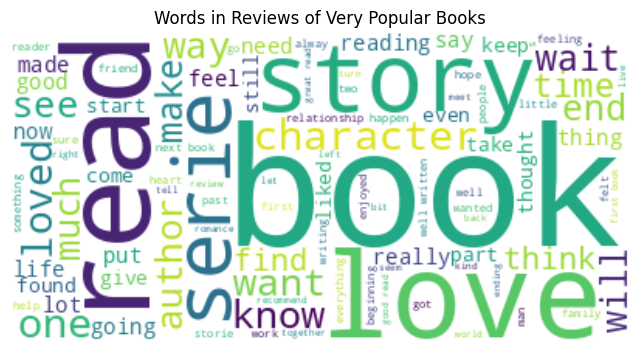

In [31]:
# For good reviews
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_popular, interpolation='bilinear')
plt.axis('off')
plt.title("Words in Reviews of Very Popular Books")
plt.show()

Big love, spotted, story, should filter out nouns like read and book and author etc.

# Overall,
## There was a lot more which could have been done. but we ended up coming up a decent model to predict the popularity and by proxy best-selling books

We did encoded some level manually the sentiment analyses in the interest of time. and not use techniques like Stem or Lattemmiser.

and got a failry decent model in the end judging by our metrics and the way they improved.

##Best,
##Zain